### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 08 декабря 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 08 декабря, -4 балла после 08:30 15 декабря, -6 баллов после 08:30 22 декабря, -8 баллов после 08:30 29 декабря.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [194]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier


In [195]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = None
        self.criterion = criterion
        # self.__Q_impurity = None
        # self.__F_impurity = None
        # self.__set_impurity()
        if self.criterion == "misclass":
            self.__F_impurity = self.__F_misclass
            self.__Q_impurity = self.__Q_misclass
        elif self.criterion == "gini":
            self.__F_impurity = self.__F_gini
            self.__Q_impurity = self.__Q_gini
        elif self.criterion == "entropy":
            self.__F_impurity = self.__F_entropy
            self.__Q_impurity = self.__Q_entropy
        else:
            raise RuntimeError('Invalid criterion name: {0}.'.format(self.criterion))
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()
    """
    def __set_impurity(self):
        if self.criterion == "misclass":
            self.__Q_impurity, self.__F_impurity = self.__Q_misclass, self.__F_misclass
        elif self.criterion == "gini":
            self.__Q_impurity, self.__F_impurity = self.__Q_gini, self.__F_gini
        elif self.criterion == "entropy":
            self.__Q_impurity, self.__F_impurity = self.__Q_entropy, self.__F_entropy
        else:
            raise RuntimeError('Invalid criterion name: {0}.'.format(self.criterion))
    """
    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __F_misclass(self, left, right):
        return np.max(np.bincount(left)) + np.max(np.bincount(right))
    
    def __F_gini(self, left, right):
        # _, bincount_left = np.unique(left, return_counts=True)
        # _, bincount_right = np.unique(right, return_counts=True)
        # return np.sum(bincount_left**2) / left.size + np.sum(bincount_right**2) / right.size
        return np.sum(np.bincount(left)**2) / left.size + np.sum(np.bincount(right)**2) / right.size
        
    def __F_entropy(self, left, right):
        _, left_cnt = np.unique(left, return_counts=True)
        _, right_cnt = np.unique(right, return_counts=True)
        res = left.size + right.size
        res += np.sum(left_cnt * np.log(left_cnt / left.size))
        res += np.sum(right_cnt * np.log(right_cnt / right.size))
    
    def __Q_misclass(self, y):
        return 1 - np.max(np.bincount(y) / y.size)
    
    def __Q_gini(self, y):
        # _, bincount_y = np.unique(y, return_counts=True)
        # return 1 - np.sum((bincount_y / y.size)**2)
        return 1 - np.sum((np.bincount(y) / y.size)**2)
    
    def __Q_entropy(self, y):
        _, cnt = np.unique(y, return_counts=True)
        return np.log2(cnt / y.size) * np.sum(cnt / y.size) * -1
    
    """
    def __calculate_impurity(self, left, right, left_s, right_s):
        res = self.__impurity(left, right)
        res -= left / (left + right) * self.__impurity(left_s, left - left_s) 
        res -= right / (left + right) * self.__impurity(right_s, right - right_s)
        #res = self.__impurity(left, right)
        #res -= self.__impurity(left_s, left - left_s) * (left / (left + right))
        #res -= self.__impurity(right_s, right - right_s) * (right / (left + right))
        return res
    """
    
    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        # Ваш код здесь
        """
        Работает медленнее, переписал
        x_ = np.sort(x.T, axis=1)
        y _ = y[np.argsort(x.T, axis=1)]
        y_= np.array(y_ == y[0], dtype='int32')
        y_ = (y_ == y[0]).astype(int)
        _, enters = np.bincount(y_[0])
        left_sum = np.cumsum(y_, axis=1)
        right_sum = enters - left_sum
        
        # inf = np.array(np.zeros(y_.shape[0]).reshape(-1, 1) + np.arange(y_.shape[1]))
        inf = np.array(np.array(range(y_.shape[1])) + np.zeros(y_.shape[0]).reshape(-1, 1))
        inf[:, 0] += 1
        impurities = self.__calculate_impurity(inf, y_.shape[1] - 1, left_sum, right_sum)
        max_impurity = np.argmax(impurities)
        best_feature_id, threshold_index = np.unravel_index(max_impurity, impurities.shape)
        # best_feature_id, threshold, crit_val = self.__find_threshold(x, y)
        threshold = x_[best_feature_id, threshold_index]
        crit_val = impurities[best_feature_id, threshold_index]
        return (best_feature_id, threshold, crit_val)
        """
        
        best_threshold, best_threshold_id, best_score = None, None, 0
        
        x_sorted = np.sort(x, axis=0)
        y_sorted = y[np.argsort(x, axis=0)]
        # перемешаем признаки
        ind_ = np.arange(x.shape[1])
        np.random.shuffle(ind_)
        feature_ids = ind_[:x.shape[1]]
        
        for feature_id in feature_ids:
            x_sorted_feat = x_sorted[:, feature_id]
            y_sorted_feat = y_sorted[:, feature_id]
            tmp = np.where((x_sorted_feat[1:] != x_sorted_feat[:-1]) &
                           (y_sorted_feat[:-1] != y_sorted_feat[1:]))
            all_idx = tmp[0] + 1
            # маска
            all_idx = all_idx[(self.min_samples_split <= all_idx) &
                              (all_idx <= y_sorted_feat.size - self.min_samples_split)]
            if all_idx.size != 0: # иначе следующая итерация цикла
                scores = [self.__F_impurity(y_sorted_feat[cnt:], y_sorted_feat[:cnt]) for cnt in all_idx]
                scores = np.array(scores, dtype='float')
                idx_best = np.argmax(scores)
                if best_score < scores[idx_best]:
                    best_score, best_threshold_id = scores[idx_best], feature_id
                    if all_idx[idx_best] > 0:
                        tmp = all_idx[idx_best]
                        best_threshold = 0.5 * (x_sorted_feat[tmp - 1] + x_sorted_feat[tmp])
                    else:
                        best_threshold = None
        return (best_threshold, best_threshold_id)

    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        # Ваш код здесь
        """
        Работает медленнее, переписал
        predict = classes[np.argsort(-cnt)][0]
        prob = cnt / y.size
        
        if depth == self.max_depth or y.size < self.min_samples_split: # LEAF_TYPE
            self.tree[node_id] = (self.LEAF_TYPE, predict, prob)
            return
        
        best_feature_id, threshold, crit_val = self.__find_threshold(x, y)
        x_left, x_right, y_left, y_right = self.__div_samples(x, y, best_feature_id, threshold)

        if y_left.size == 0 or y_right.size == 0: # LEAF_TYPE
            self.tree[node_id] = (self.LEAF_TYPE, predict, prob)
            return

        self.tree[node_id] = (self.NON_LEAF_TYPE, best_feature_id, threshold)
        self.feature_importances_[best_feature_id] += y.size * crit_val / x.shape[0]
        """
        classes_y, cnt_y = np.unique(y, return_counts=True)
        
        if depth == self.max_depth or self.min_samples_split > x.shape[0] or classes_y.size == 1:
            y_bincount = np.bincount(y)
            predict = np.argmax(y_bincount)
            prob = y_bincount / y.size
            self.tree[node_id] = (self.LEAF_TYPE, predict, prob)
            return
        
        best_threshold, best_feature_id = self.__find_threshold(x, y)
        if best_threshold is None:
            y_bincount = np.bincount(y)
            predict = np.argmax(y_bincount)
            prob = y_bincount / y.size
            self.tree[node_id] = (self.LEAF_TYPE, predict, prob)
            return
        
        #NON_LEAF_TYPE
        x_left, x_right, y_left, y_right = self.__div_samples(x, y, best_feature_id, best_threshold)
        
        self.tree[node_id] = (self.NON_LEAF_TYPE, best_feature_id, best_threshold)
        
        self.feature_importances_[best_feature_id] += self.__Q_impurity(y)
        self.feature_importances_[best_feature_id] -=  y_left.size / y.size * self.__Q_impurity(y_left)
        self.feature_importances_[best_feature_id] -= y_right.size / y.size * self.__Q_impurity(y_right)
        self.__fit_node(x_left, y_left, 2 * node_id + 1, depth + 1)
        self.__fit_node(x_right, y_right, 2 * node_id + 2, depth + 1)
        
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        y = np.array(y, dtype='int32')
        self.num_class = np.unique(y).size
        self.feature_importances_ = np.zeros(x.shape[1])
        self.__fit_node(x, y, 0, 0) 

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        # Ваш код здесь
        return self.feature_importances_

In [196]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [197]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [198]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [199]:
accuracy_score(y_pred=clf.predict(X_test), y_true=y_test), accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

(0.8888888888888888, 0.8333333333333334)

## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [200]:
%time clf.fit(X_train, y_train)

CPU times: user 1.49 ms, sys: 0 ns, total: 1.49 ms
Wall time: 9.57 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [201]:
%time my_clf.fit(X_train, y_train)

CPU times: user 21.6 ms, sys: 0 ns, total: 21.6 ms
Wall time: 22.8 ms


Wall time: 9.57 ms Vs Wall time 22.8 ms

## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [202]:
df = pd.read_csv('Speed Dating Data.csv', encoding='latin1')
df = df.iloc[:, :97]
# Предобработка

df = df.drop(['id', 'from', 'idg', 'condtn',
              'round', 'wave', 'position',
              'positin1', 'order', 'partner'], axis=1)
df = df.drop(['age_o', 'race_o', 'pf_o_att', 
              'pf_o_sin', 'pf_o_int',
              'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
              'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
              'amb_o', 'shar_o', 'like_o', 'prob_o','met_o'], axis=1)
df = df.drop(['field', 'undergra'], axis=1)

df = df.dropna(subset = ['age', 'imprelig', 'imprace'])

df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)
df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float)
df.loc[:, 'tuition'] = df.loc[:, 'tuition'].str.replace(',', '').astype(np.float)
df.loc[:, 'zipcode'] = df.loc[:, 'zipcode'].str.replace(',', '').astype(np.float)
df.loc[:, 'income'] = df.loc[:, 'income'].str.replace(',', '').astype(np.float)

df['mn_sat'] = df['mn_sat'].fillna(0.0)
df['tuition'] = df['tuition'].fillna(0.0)
df['income'] = df['income'].fillna(0.0)
df['career_c'] = df['career_c'].fillna(0.0)

df = df.dropna(subset=['date'])

df = df.drop(['career', 'sports','tvsports','exercise','dining',
              'museums','art','hiking','gaming', 'clubbing',
              'reading','tv','theater','movies', 'concerts',
              'music','shopping','yoga', 'expnum'], axis = 1)

df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 
                                        'intel1_1', 'fun1_1', 
                                        'amb1_1', 'shar1_1']].sum(axis = 1)
df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] = \
(df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 
            'amb1_1', 'shar1_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1',
                                        'intel2_1', 'fun2_1',
                                        'amb2_1', 'shar2_1']].sum(axis=1)
df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] = \
(df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1',
            'amb2_1', 'shar2_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100
df = df.drop(['temp_totalsum'], axis = 1)
df = df.dropna()

for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
            'intel{}_1'.format(i), 'fun{}_1'.format(i), 
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    if i != 4:
        feat.remove('shar{}_1'.format(i))
    df = df.drop(feat, axis=1)

df_male = df.query('gender == 1').drop_duplicates(subset = ['iid', 'pid'])\
                                 .drop(['gender'], axis = 1)\
                                 .dropna()
df_female = df.query('gender == 0').drop_duplicates(subset = ['iid'])\
                                   .drop(['gender', 'match', 'int_corr', 'samerace'], axis = 1)\
                                   .dropna()

df_female.columns = df_female.columns + '_f'

In [203]:
df = df_male.join(df_female).fillna(value=0)
df = df.drop(['iid', 'pid'], axis=1)

X, y = np.array(df.drop(['match'], axis = 1)), np.array(df['match'], dtype='int32')
X, y, df.shape, X.shape, y.shape

(array([[ 5.0e-02,  0.0e+00,  3.2e+01, ...,  0.0e+00,  0.0e+00,  0.0e+00],
        [ 4.3e-01,  1.0e+00,  3.2e+01, ...,  0.0e+00,  0.0e+00,  0.0e+00],
        [ 1.9e-01,  0.0e+00,  3.2e+01, ...,  0.0e+00,  0.0e+00,  0.0e+00],
        ...,
        [-4.6e-01,  0.0e+00,  2.5e+01, ...,  0.0e+00,  0.0e+00,  0.0e+00],
        [ 6.2e-01,  0.0e+00,  2.5e+01, ...,  0.0e+00,  0.0e+00,  0.0e+00],
        [ 1.0e-02,  0.0e+00,  2.5e+01, ...,  0.0e+00,  0.0e+00,  0.0e+00]]),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 (1988, 67),
 (1988, 66),
 (1988,))

In [204]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

features = df.columns[1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [205]:
%time my_clf.fit(X_train, y_train)

CPU times: user 93 ms, sys: 2.95 ms, total: 95.9 ms
Wall time: 96.3 ms


In [206]:
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.8442211055276382

In [207]:
f1_score(y_pred=my_clf.predict(X_test), y_true=y_test, average='macro')

0.49706050202458485

Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [210]:
k_fold = KFold(n_splits=3, shuffle=True)
crit_ = ['misclass', 'gini', 'entropy']
tree_depth_ = np.linspace(2, 20, num=10, endpoint=True, dtype='int32')
min_samples_ = np.linspace(2, 20, num=10, endpoint=True, dtype='int32')

# crit_ = ['misclass', 'gini']
# tree_depth_ = [10, 16]
# min_samples_ = [10, 15]
best_params, best_score = None, 0
scores = {}
# структура - score[crit][tree_depth][min_samples]
for crit in crit_:
    for tree_depth in tree_depth_:
        for min_samples in min_samples_:
            if crit not in scores:
                scores[crit] = {}
            if tree_depth not in scores[crit]:
                scores[crit][tree_depth] = []
            
            indices, k_fold_scores = k_fold.split(X), []
            clf = MyDecisionTreeClassifier(min_samples_split=min_samples,
                                           max_depth=tree_depth, criterion=crit)
            for (train, test) in indices:
                clf.fit(X[train], y[train])
                k_fold_scores.append(accuracy_score(y[test], clf.predict(X[test])))
            score = np.mean(k_fold_scores)
            scores[crit][tree_depth].append(score)
            
            if best_score < score:
                best_score = score
                best_params = (crit, tree_depth, min_samples)
                
            
            

In [211]:
print('Best model: criterion = {0}, max_depth = {1}, min_samples = {2}.'.format(*best_params))
print('Best score: {0}.'.format(best_score))

Best model: criterion = misclass, max_depth = 8, min_samples = 18.
Best score: 0.850112172841869.


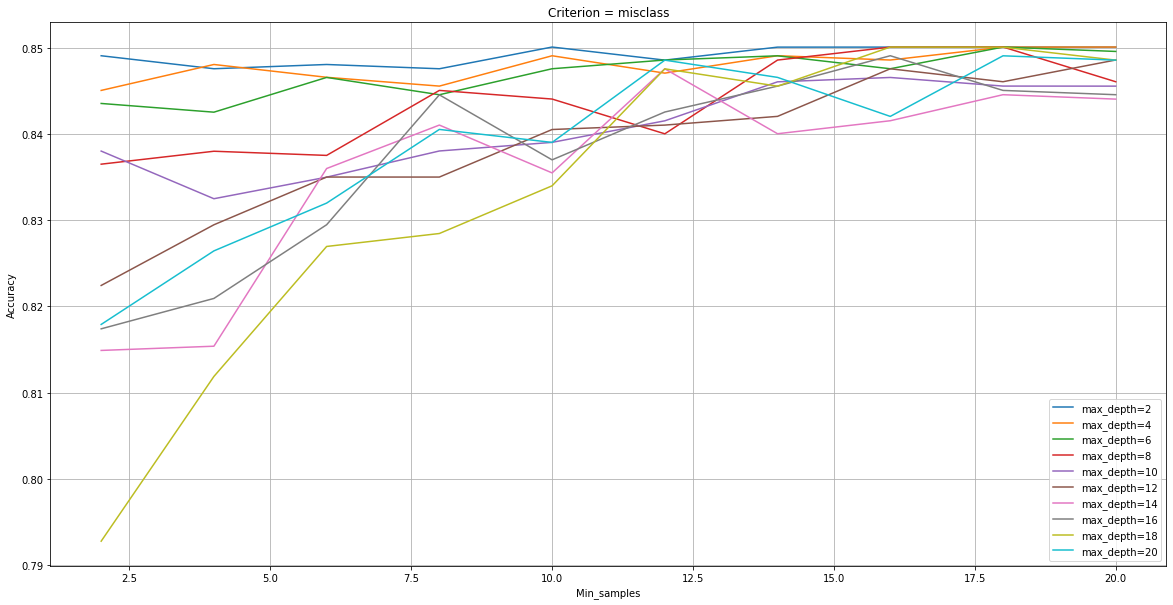

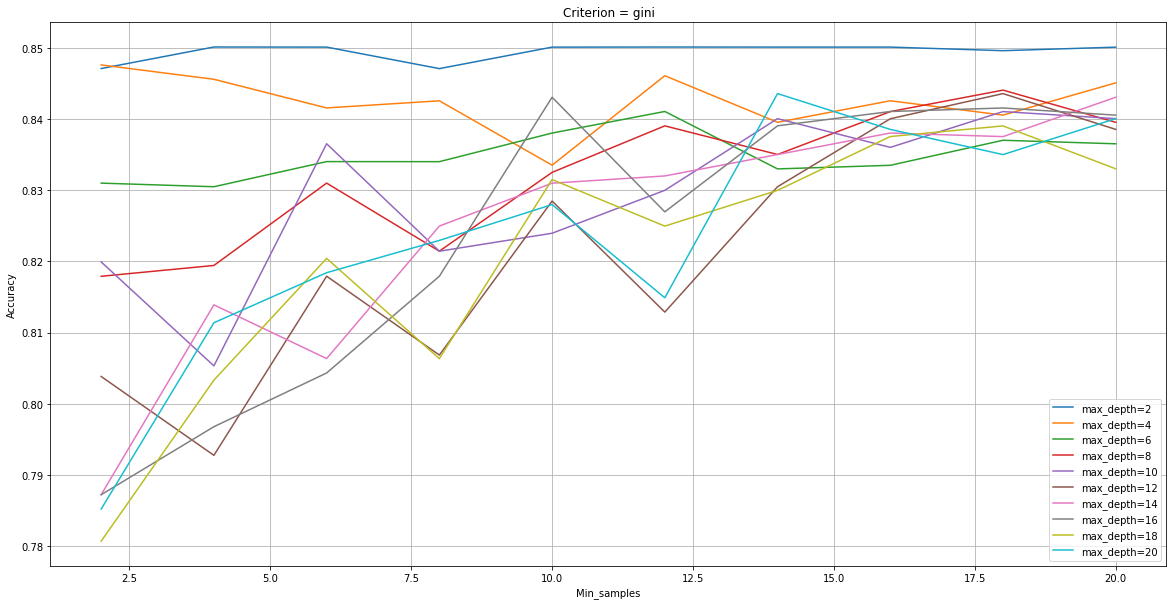

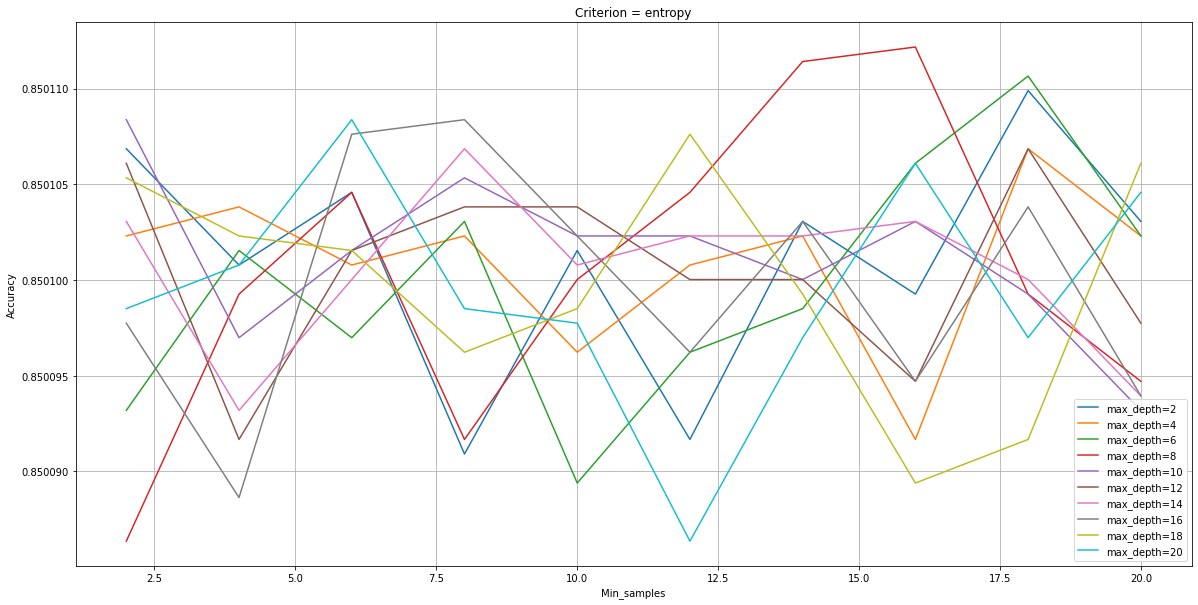

In [212]:
for crit in crit_:
    plt.figure(figsize=(20,10))
    for tree_depth in tree_depth_:
        plt.plot(min_samples_, scores[crit][tree_depth], label='max_depth={0}'.format(tree_depth))
    plt.title('Criterion = {0}'.format(crit))
    plt.xlabel('Min_samples')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [213]:
feature_names = df.drop(['match'], axis=1).columns
cnt = 10

In [214]:
def get_best_features(importance, names, cnt):
    sorted_indices = np.argsort(importance)[::-1]
    res = [(names[i], importance[i]) for i in sorted_indices]
    return res[:cnt]

In [215]:
# (min_samples_split, max_depth, criterion)
best_misclass = (18, 8, 'misclass')
best_gini = (6, 2, 'gini')
best_entropy = (16, 8, 'entropy')

In [216]:
clf = DecisionTreeClassifier(min_samples_split=best_params[2], max_depth=best_params[1], criterion='gini')
clf.fit(X, y)
print('Most important features for sklearn.tree.DecisionTreeClassifier (criterion = gini)')
get_best_features(clf.feature_importances_, feature_names, cnt)

Most important features for sklearn.tree.DecisionTreeClassifier (criterion = gini)


[('int_corr', 0.33246658063871537),
 ('imprelig', 0.07400292252040346),
 ('amb2_1', 0.06024735852993848),
 ('fun1_1', 0.05903112733470831),
 ('samerace', 0.057719576890620204),
 ('shar2_1', 0.050664898108397714),
 ('tuition', 0.04335784119157858),
 ('mn_sat', 0.036904837016672964),
 ('attr3_1', 0.030620049251281544),
 ('intel2_1', 0.030174936546586494)]

In [217]:
my_clf = MyDecisionTreeClassifier(min_samples_split=best_misclass[0],
                                  max_depth=best_misclass[1], criterion=best_misclass[2])
my_clf.fit(X, y)
feature_importance = my_clf.get_feature_importance()
print('Most important features (criterion = misclass)')
get_best_features(feature_importance, feature_names, cnt)

Most important features (criterion = misclass)


[('zipcode', 8.326672684688674e-17),
 ('amb3_1', 5.898059818321144e-17),
 ('attr2_1', 5.551115123125783e-17),
 ('career_c', 5.551115123125783e-17),
 ('fun1_1', 4.683753385137379e-17),
 ('samerace', 2.7755575615628914e-17),
 ('date', 2.7755575615628914e-17),
 ('income', 2.0816681711721685e-17),
 ('exphappy', 2.0816681711721685e-17),
 ('imprelig', 2.0816681711721685e-17)]

## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

